# Import libraries

In [ ]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import json
from time import time

# Import utils.py
!gdown 'https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0' -O ./utils.py
from utils import *

Downloading...
From: https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0
To: /content/utils.py
100% 8.03k/8.03k [00:00<00:00, 5.83MB/s]


# Omics retrieval

## Download GDC client

In [ ]:
# Download gdc-client
if not os.path.exists("gdc-client"):
    !wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
    !unzip -n gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
    !rm gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip

## Download manifest and json files

In [ ]:
# Create new folder in which to store manifest and json files
!mkdir -p manifest_and_json



# Download manifest and json files
if not os.path.exists("./manifest_and_json/mRNA_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17Gug68HBoqiVCv4dKQzIkUjj_avPzWDp' -O ./manifest_and_json/mRNA_manifest.txt
if not os.path.exists("./manifest_and_json/mRNA.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nsz215nhqSKTo0OUECmUbFNVWR60Nvns' -O ./manifest_and_json/mRNA.json

if not os.path.exists("./manifest_and_json/miRNA_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xFmsPIvZmY6FtoXpUYuoonCa6WSfQJl0' -O ./manifest_and_json/miRNA_manifest.txt
if not os.path.exists("./manifest_and_json/miRNA.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10Q_jiKv9hQ9paJGOiWkR1N9pANi0a43w' -O ./manifest_and_json/miRNA.json

if not os.path.exists("./manifest_and_json/meth_450_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=104b8Vqd6bTkyqUihilmVH5bXLYQSPKi5' -O ./manifest_and_json/meth_450_manifest.txt
if not os.path.exists("./manifest_and_json/meth_450.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ig17Mvbw-t7DEEFVoPFBkpVi4eYAsr8V' -O ./manifest_and_json/meth_450.json

if not os.path.exists("./manifest_and_json/cnv_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17UR_qxZ7CaJHiVlnkXKLIU2Ho5BMedUK' -O ./manifest_and_json/cnv_manifest.txt
if not os.path.exists("./manifest_and_json/cnv.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MQTV4mk_sVYN7Nz71zKMoVz4li7qh3Qb' -O ./manifest_and_json/cnv.json

# Download the list of the relative indices of the probes of a illumina meth 450k
# which are in common between the Illumina human methylation 27 and 450 platforms
# NB: the file meth_450_indices.txt has been obtained in the colab notebook 'Find common meth probes illumina 27k/450k'
if not os.path.exists("meth_450_indices.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IECKLh5TALSoaoaUQsfP7Cw0Gud-g5_6' -O meth_450_indices.txt
    

--2021-07-15 10:30:07--  https://docs.google.com/uc?export=download&id=17Gug68HBoqiVCv4dKQzIkUjj_avPzWDp
Resolving docs.google.com (docs.google.com)... 173.194.74.102, 173.194.74.139, 173.194.74.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.74.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/klhvit9mek6ngve47c94krhn8edg1rgs/1626345000000/05588580840073678935/*/17Gug68HBoqiVCv4dKQzIkUjj_avPzWDp?e=download [following]
--2021-07-15 10:30:08--  https://doc-0o-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/klhvit9mek6ngve47c94krhn8edg1rgs/1626345000000/05588580840073678935/*/17Gug68HBoqiVCv4dKQzIkUjj_avPzWDp?e=download
Resolving doc-0o-1g-docs.googleusercontent.com (doc-0o-1g-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-0o-1g-docs.googleusercontent.com (doc-0o-1g-

## Cross json files

 to keep only the samples for which we have all the omics

In [ ]:
# Read the mRNA json file
with open('manifest_and_json/mRNA.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to the CPTAC-3 project
df = df[df["project.project_id"] != "CPTAC-3"]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
mRNA_df = df.drop_duplicates(subset='case_id', keep=False)

mRNA_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,9582b436-145b-4f84-8f7f-8b39b8254cc1,TCGA-LUAD,a9452e8a-decb-49e4-b4f6-3db74539643b.FPKM-UQ.t...
1,9c7875ad-ab71-4d48-b2e3-e4c7a46393e9,TCGA-LUAD,022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM-UQ.t...
2,6bffe800-ec2b-4638-9333-97fe85dcd91c,TCGA-LUAD,508976fe-e7a9-4743-a098-2fb0cbe32f8d.FPKM-UQ.t...
3,3434b91a-c05f-460f-a078-7b1bb6e7085d,TCGA-LUAD,780ab54f-9100-447b-ba9e-75480e7be3d9.FPKM-UQ.t...
4,63bd2175-4b7c-44c9-aef3-9efc8f79837b,TCGA-LUAD,bfd76989-9812-4065-9e07-22a1bc498018.FPKM-UQ.t...
...,...,...,...
1252,03016c31-a2eb-4a04-9e98-f10e0c64fe9e,TCGA-LUSC,88cf0020-b8b7-4d6e-a5e9-313ee7dcf479.FPKM-UQ.t...
1253,947b20ae-f6e3-497d-96d6-db0b9cab3c5a,TCGA-LUSC,790e54f3-e786-4f54-a34a-23e640af778d.FPKM-UQ.t...
1254,861d45aa-b15d-4e7e-b751-f55a64c4cac3,TCGA-LUSC,23bd99eb-f3b4-4c47-9eed-b71aa24f5112.FPKM-UQ.t...
1255,dff43217-7857-42ca-b87b-058c774a6aa7,TCGA-LUSC,9b080ec7-d075-42a6-b6b5-ba57e2791fc7.FPKM-UQ.t...


In [ ]:
# Read the miRNA json file
with open('manifest_and_json/miRNA.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to the CPTAC-3 project
df = df[df["project.project_id"] != "CPTAC-3"]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
miRNA_df = df.drop_duplicates(subset='case_id', keep=False)

miRNA_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,5134c56f-8286-4ec8-8348-237cee7dad5e,TCGA-LUAD,80ba5897-8a92-4c15-affd-a78c9e1d5f2a.mirbase21...
1,e8060c45-451d-4779-9584-f284db47e63e,TCGA-LUAD,05417b04-aae6-479f-b564-0f5634180b90.mirbase21...
2,cc4bd56a-25c5-4c48-b583-ac3aeb778ca6,TCGA-LUAD,05111cac-b52d-4da1-888f-7e346275e1a7.mirbase21...
3,742e0e32-25b5-4d41-8bf5-364b571cfd93,TCGA-LUAD,d86360eb-f641-46b1-ae85-b9642f9d2258.mirbase21...
4,8cc6bcec-65df-46a9-a88c-09762a132857,TCGA-LUAD,937cb8a4-7940-4c47-bfaa-115ef4115c87.mirbase21...
...,...,...,...
993,55bafaad-323b-4b92-813e-52d18d70fc3e,TCGA-LUSC,cfe0a46a-6c66-4d01-8228-9f40a411af70.mirbase21...
994,0d3c11b5-856e-4d41-b94a-b2e32f9c5792,TCGA-LUSC,d18a6e1c-d155-491c-97d3-aeaec6f6e952.mirbase21...
995,349e01b0-0c88-4321-839e-0a84edf11a73,TCGA-LUSC,a5915033-5cce-4fb1-83ca-8fbd1bb74733.mirbase21...
996,b80ea411-c8ca-4414-ad1b-82af11df11c2,TCGA-LUSC,328445a8-c19d-4352-80ff-06f2bfc415c1.mirbase21...


In [ ]:
# Read the meth_450 json file
with open('manifest_and_json/meth_450.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to the CPTAC-3 project
df = df[df["project.project_id"] != "CPTAC-3"]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
meth_450_df = df.drop_duplicates(subset='case_id', keep=False)

meth_450_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,cd9e70e4-8622-4a07-8646-63f8275c1737,TCGA-LUAD,jhu-usc.edu_LUAD.HumanMethylation450.19.lvl-3....
1,edf80622-aea2-4b50-bb69-691d6708aa83,TCGA-LUAD,jhu-usc.edu_LUAD.HumanMethylation450.3.lvl-3.T...
2,75a0bb0b-6528-4fb8-a9e6-254905d21df4,TCGA-LUAD,jhu-usc.edu_LUAD.HumanMethylation450.15.lvl-3....
3,69b23036-add9-42c9-941f-02fb74d9b08c,TCGA-LUAD,jhu-usc.edu_LUAD.HumanMethylation450.3.lvl-3.T...
4,4b7cd595-e7f9-45a8-b736-a8c7c42d9539,TCGA-LUAD,jhu-usc.edu_LUAD.HumanMethylation450.4.lvl-3.T...
...,...,...,...
839,234c7de4-ce5b-4a2f-ac46-9da61cff1680,TCGA-LUSC,jhu-usc.edu_LUSC.HumanMethylation450.12.lvl-3....
840,86b165c2-d0e6-4a4f-84ed-aa95e3133627,TCGA-LUSC,jhu-usc.edu_LUSC.HumanMethylation450.6.lvl-3.T...
841,3374e5d9-b627-4d4c-b66b-422f9564695e,TCGA-LUSC,jhu-usc.edu_LUSC.HumanMethylation450.16.lvl-3....
842,12b44011-90c0-4a70-8ea4-a216ec0c0860,TCGA-LUSC,jhu-usc.edu_LUSC.HumanMethylation450.13.lvl-3....


In [ ]:
# Read the cnv json file
with open('manifest_and_json/cnv.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to the CPTAC-3 project
df = df[df["project.project_id"] != "CPTAC-3"]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
cnv_df = df.drop_duplicates(subset='case_id', keep=False)

cnv_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,0d980584-4484-4063-8243-c3cd67f6f588,TCGA-LUAD,TCGA-LUAD.1ec915da-e300-4169-b7be-7ab4b61af1ef...
1,36ad7fc7-0cc1-4f01-aef1-f89b3cb4feac,TCGA-LUAD,TCGA-LUAD.5f204e58-65a1-4d9e-b9ca-777e007934af...
2,fcfe0b53-dfc1-42fa-9efc-2b2ff259297e,TCGA-LUAD,TCGA-LUAD.a163b78e-b83e-4e4b-9fdd-fede826ceb9e...
3,77f8c850-b4e6-46a1-ab12-a50e0044a0c8,TCGA-LUAD,TCGA-LUAD.7126f09a-ebf2-4795-8965-5ee0fcbf56e5...
4,4b22ad71-c585-4077-ad3c-c6e026d0c7fa,TCGA-LUAD,TCGA-LUAD.e950d7d9-06d5-48d7-925d-f63f8bcf34f7...
...,...,...,...
1273,a402e786-132c-4095-bb75-22be04b5d835,TCGA-LUSC,TCGA-LUSC.d0f1f6bb-2302-48c8-b3bb-e21b4508faaf...
1274,a6ec75d4-1c90-4527-bfae-aa91d2dae082,TCGA-LUSC,TCGA-LUSC.ad8af792-723b-416f-ab42-3357a1d4de4c...
1275,185923c0-e642-41c4-a22e-0dae102b0a40,TCGA-LUSC,TCGA-LUSC.1b5538d7-a773-4ab5-b47d-7e5a8ff7b43f...
1276,fc6fa488-f8e3-4336-97dc-bd8c087c70e6,TCGA-LUSC,TCGA-LUSC.0253cd5d-a580-443d-ab89-b00a5971d025...


In [ ]:
# Outer join on mRNA_df.case_id == miRNA_df.case_id == meth_450_df.case_id == cnv_df.case_id
col_mask = [col for col in mRNA_df.columns if col != "project.project_id"] # we want to drop the project_id in miRNA_df, meth_450_df, cnv_df, so to avoid duplicate columns when merging

merged_df = mRNA_df.merge(miRNA_df[col_mask], how='outer', on="case_id", suffixes=('_mRNA', '_miRNA')) \
                   .merge(cnv_df[col_mask], how='outer', on="case_id").rename(columns={'file_name':'file_name_cnv'}) \
                   .merge(meth_450_df[col_mask], how='outer', on="case_id").rename(columns={'file_name':'file_name_meth_450'}) \

# Drop rows with NaN values (i.e., we don't have all the omics for that patient, so we discard it)
merged_df = merged_df.dropna()

# Keep only samples associated with a tumor which is TCGA-LUAD or TCGA-LUSC (because TCGA-MESO is also present)
merged_df = merged_df[(merged_df['project.project_id'] == 'TCGA-LUAD') | (merged_df['project.project_id'] == 'TCGA-LUSC')]

# Reset the numeration of the indices
merged_df = merged_df.reset_index(drop=True)

merged_df

,case_id,project.project_id,file_name_mRNA,file_name_miRNA,file_name_cnv,file_name_meth_450
0,9582b436-145b-4f84-8f7f-8b39b8254cc1,TCGA-LUAD,a9452e8a-decb-49e4-b4f6-3db74539643b.FPKM-UQ.t...,3d064976-8d4b-41a4-9fc8-52b12d23888c.mirbase21...,TCGA-LUAD.2557e6de-4f50-4b1f-a1f3-9fae683d41e9...,jhu-usc.edu_LUAD.HumanMethylation450.11.lvl-3....
1,9c7875ad-ab71-4d48-b2e3-e4c7a46393e9,TCGA-LUAD,022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM-UQ.t...,0765c335-1688-4d47-a05c-05213efa89b0.mirbase21...,TCGA-LUAD.06a2b6c8-6306-43a8-9008-937c4d8995d9...,jhu-usc.edu_LUAD.HumanMethylation450.4.lvl-3.T...
2,6bffe800-ec2b-4638-9333-97fe85dcd91c,TCGA-LUAD,508976fe-e7a9-4743-a098-2fb0cbe32f8d.FPKM-UQ.t...,5a9f1911-3ee9-4d07-b05e-84999d9c65a1.mirbase21...,TCGA-LUAD.b36580ea-acfc-4121-b610-105157f3f15e...,jhu-usc.edu_LUAD.HumanMethylation450.4.lvl-3.T...
3,63bd2175-4b7c-44c9-aef3-9efc8f79837b,TCGA-LUAD,bfd76989-9812-4065-9e07-22a1bc498018.FPKM-UQ.t...,9ff44c45-7e42-41bb-bedb-067996511051.mirbase21...,TCGA-LUAD.73555199-0741-4552-ae86-3df91f8b283e...,jhu-usc.edu_LUAD.HumanMethylation450.2.lvl-3.T...
4,258a3a41-211b-4c66-bd3b-ef03014a6967,TCGA-LUAD,7160e771-bab5-4ca6-a2da-65fdc4b8358d.FPKM-UQ.t...,e5a63f4b-d39d-476f-a3e6-81f8249fe85a.mirbase21...,TCGA-LUAD.565d8f45-819a-46b7-8697-92fb545cdb6f...,jhu-usc.edu_LUAD.HumanMethylation450.14.lvl-3....
...,...,...,...,...,...,...
778,b206617b-90a7-4467-b2ba-2000b2c6992d,TCGA-LUSC,f3bc810a-edc7-4412-9e09-006c0bcf2550.FPKM-UQ.t...,16b35f94-2993-4197-a762-52ecb9a464aa.mirbase21...,TCGA-LUSC.7807fb8e-3110-4bef-808f-3f2be8a2ab25...,jhu-usc.edu_LUSC.HumanMethylation450.6.lvl-3.T...
779,03016c31-a2eb-4a04-9e98-f10e0c64fe9e,TCGA-LUSC,88cf0020-b8b7-4d6e-a5e9-313ee7dcf479.FPKM-UQ.t...,6803ef84-208b-43dd-bb19-f337d0c10de4.mirbase21...,TCGA-LUSC.f6469547-7a14-4d75-aa91-d45a455693a6...,jhu-usc.edu_LUSC.HumanMethylation450.6.lvl-3.T...
780,947b20ae-f6e3-497d-96d6-db0b9cab3c5a,TCGA-LUSC,790e54f3-e786-4f54-a34a-23e640af778d.FPKM-UQ.t...,734e0afa-10fe-474e-b4b5-a9646de1e0aa.mirbase21...,TCGA-LUSC.0126fcbe-39a6-4b89-9fc3-0dae79cdacd2...,jhu-usc.edu_LUSC.HumanMethylation450.17.lvl-3....
781,861d45aa-b15d-4e7e-b751-f55a64c4cac3,TCGA-LUSC,23bd99eb-f3b4-4c47-9eed-b71aa24f5112.FPKM-UQ.t...,3e1fd0af-6037-45bb-bb7d-b6c8a4bc0160.mirbase21...,TCGA-LUSC.2f3785d8-ac84-48c0-b133-4c0932b9c7ca...,jhu-usc.edu_LUSC.HumanMethylation450.11.lvl-3....


In [ ]:
# Creation of clusters.txt

def pid_to_n(pid):
    if pid == 'TCGA-LUAD':
        return 0
    elif pid == 'TCGA-LUSC':
        return 1
    else:
        return 2    # never taken

merged_df_sorted = merged_df.sort_values('case_id').set_index('case_id')
clusters_df = merged_df_sorted[['project.project_id']].applymap(pid_to_n)
clusters_df.index.name = None
clusters_df = clusters_df.rename(columns={'project.project_id':'tumor_id'})

clusters_df.to_csv('clusters.txt', sep='\t', index_label='case_id')

n_luad = np.sum(clusters_df['tumor_id'] == 0)    # #TCGA-LUAD samples
n_lusc = np.sum(clusters_df['tumor_id'] == 1)    # #TCGA-LUSC samples
print(f"N. of TCGA-LUAD samples: {n_luad}")
print(f"N. of TCGA-LUSC samples: {n_lusc}")

N. of TCGA-LUAD samples: 429
N. of TCGA-LUSC samples: 354


## Update manifest files

In [ ]:
omics = ['meth_450','mRNA','miRNA','cnv']

# Let's write our new manifest files
for omic in omics:
    df = pd.read_csv(f'manifest_and_json/{omic}_manifest.txt', sep='\t')
    filenames = merged_df[f'file_name_{omic}']
    df = df.loc[df['filename'].isin(filenames)]
    df.to_csv(f'manifest_and_json/{omic}_manifest_MOD.txt', sep='\t', index=False)


## Download omics data

In [ ]:
# This command is needed in case the next cell was already run a first time
!rm -r meth_450_gdc_files meth_450_temp

rm: cannot remove 'meth_450_gdc_files': No such file or directory
rm: cannot remove 'meth_450_temp': No such file or directory


In [ ]:
# Download data from the GDC portal
# WARNING: meth is very heavy to download, so we download it and pre-process it at the same time

ds = {}     # this will contain each omic

meth_450_indices = pd.read_csv('meth_450_indices.txt').values.reshape((-1))     # filter only the CpG probes which are in common between Illumina 27k and Illumina 450k

def meth_450_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', usecols=['Composite Element REF','Beta_value'], index_col=0)
    df.index.name = None
    df = df.iloc[meth_450_indices]
    df = df.T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={'Beta_value':case_id})
    return df

for omic in omics:
    print(f"##### Now downloading: {omic}")
    dir_name = f'./{omic}_gdc_files'
    !mkdir $dir_name
    manifest_name = f'manifest_and_json/{omic}_manifest_MOD.txt'
    
    if omic == 'meth_450':
        #continue    # already downloaded
        df_rows = []
        fname_to_caseid = dict(zip(merged_df[f'file_name_meth_450'], merged_df['case_id']))
        n_patients = merged_df.shape[0]
        !mkdir meth_450_temp
        # Download each file and preprocess it
        with open(manifest_name) as f:
            header = f.readline()
            for line in f:
                with open('meth_450_manifest_TEMP.txt', 'w') as f2:
                    f2.write(header)
                    f2.write(line)
                !./gdc-client download --no-annotations --no-related-files -n 5 -m 'meth_450_manifest_TEMP.txt' -d ./meth_450_temp

                # preprocessing
                for subdir in os.listdir('meth_450_temp'):
                    subdir_full = os.path.join('meth_450_temp', subdir)
                    for fname in os.listdir(subdir_full):
                        if os.path.splitext(fname)[1] == '.txt':
                            fname_full = os.path.join(subdir_full, fname)
                            try:
                                fname_caseid = fname_to_caseid[fname]
                                fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.txt')
                                !mv $fname_full $fname_caseid_full
                            except:
                                fname_caseid_full = fname_full
                            df = meth_450_txt_to_dataframe(fname_caseid_full)
                            df_rows.append(df)
                            break
                    # Progress tracking
                    if len(df_rows) % 50 == 0:
                        print(f'{len(df_rows)} / {n_patients}')
                # we don't need the downloaded files anymore so we EMPTY the temp folder
                !rm -r meth_450_temp/*

        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()    # sorting
        ds[omic].to_csv(f'meth.txt', sep='\t', index_label='case_id')

        # at the end      
        !rm meth_450_manifest_TEMP.txt
        !rm -r meth_450_temp
    else:
        !./gdc-client download --no-annotations --no-related-files -n 5 -m $manifest_name -d $dir_name
        
    print('\n\n\n')

##### Now downloading: meth_450
100% [#############################################] Time:  0:00:02  54.6 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  62.2 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  58.9 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  62.8 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  65.0 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  63.1 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  66.0 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  61.0 MiB/s 
Successfully downloaded: 1
100% [#############################################] Time:  0:00:02  63.1 MiB/s 
Successfully downloaded

## Create datasets

In [ ]:
def mRNA_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', header=None, index_col=0).T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={1:case_id})
    return df

def miRNA_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', usecols=['miRNA_ID','reads_per_million_miRNA_mapped'], index_col=0)
    df.index.name = None
    df = df.T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={'reads_per_million_miRNA_mapped':case_id})
    return df

def cnv_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', usecols=['gene_id','chromosome','copy_number'], index_col=0)
    df.index.name = None
    # Keep only autosomic genes
    # https://www.goldenhelix.com/learning/knowledge-base/svs-microarray-cnv-quality-assurance-tutorial/#b-detecting-the-presence-of-batch-effects
    df = df.drop(df[df['chromosome'] == 'chrX'].index)
    df = df.drop(df[df['chromosome'] == 'chrY'].index)
    df = df.T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={'copy_number':case_id})
    return df.iloc[[1]]

for omic in omics:
    print(f"##### Now composing: {omic}")
    df_rows = []
    fname_to_caseid = dict(zip(merged_df[f'file_name_{omic}'], merged_df['case_id']))
    dir = f'{omic}_gdc_files'
    n_patients = len(os.listdir(f'{omic}_gdc_files'))

    if omic == 'mRNA':
        #continue
        for subdir in os.listdir(f'{omic}_gdc_files'):
            subdir_full = os.path.join(dir, subdir)
            for gzfile in os.listdir(subdir_full):
                gzfile_full = os.path.join(subdir_full, gzfile)
                gzfile_fname_full, gzfile_ext = os.path.splitext(gzfile_full)
                if gzfile_ext == '.gz':
                    !gzip -dkf $gzfile_full    # remove -k to remove also the compressed version of the .txt (i.e. the .gz file)
                    gzfile_caseid = fname_to_caseid[gzfile]
                    gzfile_new_fname_full = os.path.join(subdir_full, gzfile_caseid+'.txt')
                    !mv $gzfile_fname_full $gzfile_new_fname_full
                    df = mRNA_txt_to_dataframe(gzfile_new_fname_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'{omic}.txt', sep='\t', index_label='case_id')

    if omic == 'miRNA':
        #continue
        for subdir in os.listdir(f'{omic}_gdc_files'):
            subdir_full = os.path.join(dir, subdir)
            for fname in os.listdir(subdir_full):
                if os.path.splitext(fname)[1] == '.txt':
                    fname_full = os.path.join(subdir_full, fname)
                    try:
                        fname_caseid = fname_to_caseid[fname]
                        fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.txt')
                        !mv $fname_full $fname_caseid_full
                    except:
                        fname_caseid_full = fname_full
                    df = miRNA_txt_to_dataframe(fname_caseid_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'{omic}.txt', sep='\t', index_label='case_id')

    if omic == 'cnv':
        #continue
        for subdir in os.listdir(f'{omic}_gdc_files'):
            subdir_full = os.path.join(dir, subdir)
            for fname in os.listdir(subdir_full):
                if os.path.splitext(fname)[1] == '.tsv':
                    fname_full = os.path.join(subdir_full, fname)
                    try:
                        fname_caseid = fname_to_caseid[fname]
                        fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.tsv')
                        !mv $fname_full $fname_caseid_full
                    except:
                        fname_caseid_full = fname_full
                    df = cnv_txt_to_dataframe(fname_caseid_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'{omic}.txt', sep='\t', index_label='case_id')

    if omic == 'meth_450':
        continue    # ALREADY RETRIEVED (see previous cell)
        for subdir in os.listdir(f'{omic}_gdc_files'):
            subdir_full = os.path.join(dir, subdir)
            for fname in os.listdir(subdir_full):
                if os.path.splitext(fname)[1] == '.txt':
                    fname_full = os.path.join(subdir_full, fname)
                    try:
                        fname_caseid = fname_to_caseid[fname]
                        fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.txt')
                        !mv $fname_full $fname_caseid_full
                    except:
                        fname_caseid_full = fname_full
                    df = meth_450_txt_to_dataframe(fname_caseid_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'meth.txt', sep='\t', index_label='case_id')


##### Now composing: meth_450
##### Now composing: mRNA
50 / 783
100 / 783
150 / 783
200 / 783
250 / 783
300 / 783
350 / 783
400 / 783
450 / 783
500 / 783
550 / 783
600 / 783
650 / 783
700 / 783
750 / 783
##### Now composing: miRNA
50 / 783
100 / 783
150 / 783
200 / 783
250 / 783
300 / 783
350 / 783
400 / 783
450 / 783
500 / 783
550 / 783
600 / 783
650 / 783
700 / 783
750 / 783
##### Now composing: cnv
50 / 783
100 / 783
150 / 783
200 / 783
250 / 783
300 / 783
350 / 783
400 / 783
450 / 783
500 / 783
550 / 783
600 / 783
650 / 783
700 / 783
750 / 783


In [ ]:
'''
### TO STORE THE OMIC DS AS A TXT TABULAR FILE
ds['mRNA'].to_csv('mRNA.txt', sep='\t', index_label='case_id')

### TO READ AN OMIC DS
df = pd.read_csv('mRNA.txt', sep='\t', index_col=0)
'''

"\n### TO STORE THE OMIC DS AS A TXT TABULAR FILE\nds['mRNA'].to_csv('mRNA.txt', sep='\t', index_label='case_id')\n\n### TO READ AN OMIC DS\ndf = pd.read_csv('mRNA.txt', sep='\t', index_col=0)\n"

# Omics pre-processing

N.B.: the omics downloaded so far and saved as {omic}.txt are still to pre-process.

Preprocessing consists of:

1) deleting NaN columns

2) imputing remaining NaN values with KNNImputer


#### meth

In [ ]:
#ds['meth'] = pd.read_csv('meth.txt', sep='\t', index_col=0)
ds['meth'] = ds['meth_450']

# Delete NaN columns
df = ds['meth'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))   # n. of columns with missing values
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the most
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the least
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))  # mean n. of missing values over columns which contains them
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))    # quantiles associated to the n. of missing values of the columns

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['meth_no_missing'] = df
ds['meth_no_missing'].to_csv('meth_no_missing.txt', sep='\t', index_label='case_id')

#### mRNA

In [ ]:
#ds['mRNA'] = pd.read_csv('mRNA.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['mRNA'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['mRNA_no_missing'] = df
ds['mRNA_no_missing'].to_csv('mRNA_no_missing.txt', sep='\t', index_label='case_id')

#### miRNA

In [ ]:
#ds['miRNA'] = pd.read_csv('miRNA.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['miRNA'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['miRNA_no_missing'] = df
ds['miRNA_no_missing'].to_csv('miRNA_no_missing.txt', sep='\t', index_label='case_id')

#### cnv

In [ ]:
#ds['cnv'] = pd.read_csv('cnv.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['cnv'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['cnv_no_missing'] = df
ds['cnv_no_missing'].to_csv('cnv_no_missing.txt', sep='\t', index_label='case_id')

28323
518
1
10.977906976744187
[ 1.  1.  2.  7. 14.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

# Visualize the omics

To visualize the omics, the pre-processing steps used in 'Multi-omics clustering' colab notebook are applied

In [ ]:
try:
    ds
except:
    ds = {}

# mRNA
if not os.path.exists("./mRNA.txt"):
    !gdown 'https://drive.google.com/uc?id=1kNQxRoCs6TIGVzdlpEpUkAqx8FyoSrsi' -O ./mRNA.txt
    ds['mRNA'] = pd.read_csv('mRNA.txt', sep='\t', index_col=0)

# Keep only protein coding genes
# NB: the file idx_mRNA_prot_cod.txt, containing the protein coding genes of the
# human genome, has been obtained in the colab notebook 'Find protein coding genes'
!gdown 'https://drive.google.com/uc?id=1i6lXPIh60BtCF-ujfaqf4WrvWM4XMvNF' -O ./idx_mRNA_prot_cod.txt
idx_mRNA_prot_cod = pd.read_csv('idx_mRNA_prot_cod.txt')
idx_mRNA_prot_cod = idx_mRNA_prot_cod['idx'].values

ds['mRNA'] = ds['mRNA'].iloc[:, idx_mRNA_prot_cod]

# Delete genes with a zero expression value across all the samples
ds['mRNA'] = ds['mRNA'].loc[:, (ds['mRNA'] != 0).any(axis=0)]

# Normalize mRNA with MinMax Scaler
ds['mRNA_normalized'] = MinMaxScaler().fit_transform(ds['mRNA'].values)



# miRNA
if not os.path.exists("./miRNA.txt"):
    !gdown 'https://drive.google.com/uc?id=16V4tY8GeCUemOrf_KBqJwdixrQYZmFHv' -O ./miRNA.txt
    ds['miRNA'] = pd.read_csv('miRNA.txt', sep='\t', index_col=0)

# Delete sequences with a zero expression value across all the samples
ds['miRNA'] = ds['miRNA'].loc[:, (ds['miRNA'] != 0).any(axis=0)]

# Normalize with log2 normalization
ds['miRNA'] = np.log(ds['miRNA'] + 1) / np.log(2)

# Normalize with MinMaxScaler
ds['miRNA_normalized'] = MinMaxScaler().fit_transform(ds['miRNA'].values)



# meth
if not os.path.exists("./meth.txt"):
    !gdown 'https://drive.google.com/uc?id=1UuCNcXbxHS1lW3bRkixsbo77xIFsWxIG' -O ./meth.txt
    ds['meth'] = pd.read_csv('meth.txt', sep='\t', index_col=0)

# Delete sequences with a zero expression value across all the samples
ds['meth'] = ds['meth'].loc[:, (ds['meth'] != 0).any(axis=0)]

# Normalize with MinMaxScaler
ds['meth_normalized'] = MinMaxScaler().fit_transform(ds['meth'].values)



# cnv
if not os.path.exists("./cnv.txt"):
    !gdown 'https://drive.google.com/uc?id=1vJHt-_sHINZzeIY21Mu5KaEx_XVvpJ1y' -O ./cnv.txt
    ds['cnv'] = pd.read_csv('cnv.txt', sep='\t', index_col=0)


# Filter out duplicates of each column, so to keep only one (this filters out a lot of genes)
# The rationale behind this is that removing those columns preserves the distances between samples,
# while greatly reducing the dimensionality
ds['cnv'] = ds['cnv'].T.drop_duplicates().T

# Normalize with MinMaxScaler
ds['cnv_normalized'] = MinMaxScaler().fit_transform(ds['cnv'].values)


# True cluster labels
if not os.path.exists("./clusters.txt"):
    !gdown 'https://drive.google.com/uc?id=1t1rTrZNVHqZRo_F0YA0heD3WbvijHox7' -O ./clusters.txt
    y = pd.read_csv('clusters.txt', sep='\t', index_col=0)
    true_cluster_labels = y.values.reshape(y.shape[0])
else:
    true_cluster_labels = clusters_df.values.reshape(clusters_df.shape[0])

Downloading...
From: https://drive.google.com/uc?id=1kNQxRoCs6TIGVzdlpEpUkAqx8FyoSrsi
To: /content/mRNA.txt
459MB [00:04, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1i6lXPIh60BtCF-ujfaqf4WrvWM4XMvNF
To: /content/idx_mRNA_prot_cod.txt
100% 114k/114k [00:00<00:00, 40.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16V4tY8GeCUemOrf_KBqJwdixrQYZmFHv
To: /content/miRNA.txt
10.2MB [00:00, 47.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UuCNcXbxHS1lW3bRkixsbo77xIFsWxIG
To: /content/meth.txt
342MB [00:06, 54.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vJHt-_sHINZzeIY21Mu5KaEx_XVvpJ1y
To: /content/cnv.txt
180MB [00:01, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1t1rTrZNVHqZRo_F0YA0heD3WbvijHox7
To: /content/clusters.txt
100% 30.6k/30.6k [00:00<00:00, 43.0MB/s]


Each omic is first min-max normalized to [0,1] interval, then reduced to two dimensions with PCA, and finally the two principal components are plotted in the 2D plane

mRNA


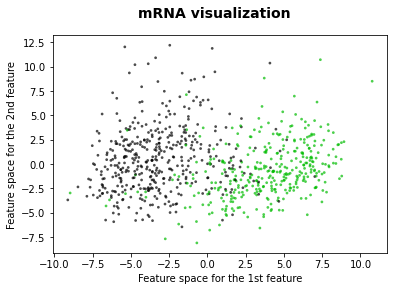



miRNA


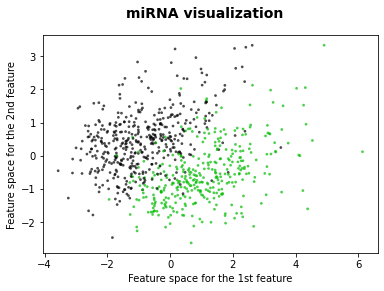



meth


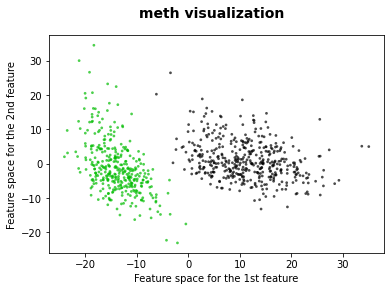



cnv


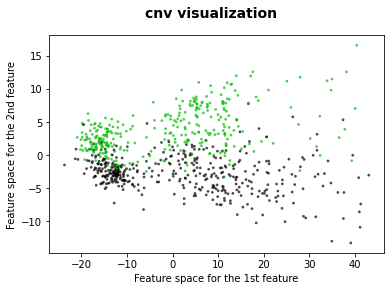

In [ ]:
for omic in ['mRNA','miRNA','meth','cnv']:
    print(omic)

    # Perform a 2D PCA to visualize the dataset
    pca = PCA(2)
    principalComponents = pca.fit_transform(ds[f'{omic}_normalized'])

    # Plot the clustered dataset with true cluster labels
    plot_2D_dataset(principalComponents, true_cluster_labels, title=f'{omic} visualization')

    print()
    print()

# CNV batch effect correction

## Try to explain the batch effect with clinical attributes of the patients

In [ ]:
# Load clinical data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12t0GbE8EXxLQOJezObAOwzbHma2EIsKB' -O clinical_info.json

# Import it in python
with open('clinical_info.json') as f:
    data = json.load(f)
df = pd.json_normalize(data, max_level=4)
df = df.drop(index=[508])   # full of nan values

x1 = []
x2 = []
x3 = []
x4 = []
idx_to_remove = []
for i in range(df.shape[0]):
    if type(df['diagnoses'].values[i]) != float:
        x1.append(df['diagnoses'].values[i][0]['synchronous_malignancy'])
        x2.append(df['diagnoses'].values[i][0]['tissue_or_organ_of_origin'])
        x3.append(df['diagnoses'].values[i][0]['primary_diagnosis'])
        x4.append(df['diagnoses'].values[i][0]['site_of_resection_or_biopsy'])
    else:
        idx_to_remove.append(i)

df = df.drop(index=idx_to_remove)

df['synchronous_malignancy'] = x1
df['tissue_or_organ_of_origin'] = x2
df['primary_diagnosis'] = x3
df['site_of_resection_or_biopsy'] = x4
df = df.drop(columns=['exposures', 'diagnoses', 'demographic.submitter_id', 'demographic.days_to_birth', 'demographic.created_datetime', 'demographic.year_of_birth', 'demographic.demographic_id', 'demographic.updated_datetime', 'demographic.state', 'demographic.year_of_death'])

clinical_df = df
clinical_df

--2021-07-15 10:59:57--  https://docs.google.com/uc?export=download&id=12t0GbE8EXxLQOJezObAOwzbHma2EIsKB
Resolving docs.google.com (docs.google.com)... 173.194.74.102, 173.194.74.138, 173.194.74.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.74.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6u4k4a4b78h5qvgrt5hg2916k4ofok62/1626346725000/05588580840073678935/*/12t0GbE8EXxLQOJezObAOwzbHma2EIsKB?e=download [following]
--2021-07-15 10:59:58--  https://doc-08-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6u4k4a4b78h5qvgrt5hg2916k4ofok62/1626346725000/05588580840073678935/*/12t0GbE8EXxLQOJezObAOwzbHma2EIsKB?e=download
Resolving doc-08-1g-docs.googleusercontent.com (doc-08-1g-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-08-1g-docs.googleusercontent.com (doc-08-1g-

,case_id,demographic.race,demographic.ethnicity,demographic.gender,demographic.vital_status,demographic.age_at_index,demographic.days_to_death,synchronous_malignancy,tissue_or_organ_of_origin,primary_diagnosis,site_of_resection_or_biopsy
0,14a4a93a-e24d-46f2-bee3-18bd792ef95a,white,not hispanic or latino,male,Alive,70.0,NaN,No,"Upper lobe, lung","Squamous cell carcinoma, NOS","Upper lobe, lung"
1,037c57d1-b4a5-45dc-bda4-0550461d321b,white,not hispanic or latino,male,Dead,65.0,822.0,No,"Lung, NOS","Squamous cell carcinoma, NOS","Lung, NOS"
2,a2d7c06b-efa9-4b7e-9ea6-b47c9ad6ef38,not reported,not reported,female,Alive,70.0,NaN,No,"Upper lobe, lung","Squamous cell carcinoma, NOS","Upper lobe, lung"
3,99daa971-31d0-4c37-9c12-b0dc42ddd19b,white,not hispanic or latino,male,Alive,70.0,NaN,Yes,"Lower lobe, lung","Squamous cell carcinoma, NOS","Lower lobe, lung"
4,f400b427-954a-4f8a-a885-222e3e4c28ab,black or african american,not hispanic or latino,male,Dead,60.0,3600.0,No,"Upper lobe, lung","Squamous cell carcinoma, NOS","Upper lobe, lung"
...,...,...,...,...,...,...,...,...,...,...,...
1047,abb86d09-d4ff-41f4-ba22-185dc48347c9,NaN,NaN,NaN,NaN,NaN,NaN,Not Reported,"Upper lobe, lung","Adenocarcinoma, NOS","Upper lobe, lung"
1048,34040b83-7e8a-4264-a551-b16621843e28,not reported,not reported,male,Alive,70.0,NaN,No,"Lower lobe, lung","Adenocarcinoma, NOS","Lower lobe, lung"
1050,a16d7bf7-07b7-4320-969c-fc68dd564a92,NaN,NaN,NaN,NaN,NaN,NaN,No,"Lower lobe, lung","Adenocarcinoma, NOS","Lower lobe, lung"
1051,fb79c491-7b01-42ae-8369-8364e442e31b,white,not hispanic or latino,female,Alive,55.0,NaN,No,"Upper lobe, lung","Adenocarcinoma, NOS","Upper lobe, lung"


In [ ]:
merged_df = merged_df.reset_index()
merged_clinical_df = merged_df.merge(clinical_df, how='inner', on="case_id", suffixes=('_omics', '_clinical'))

# Reset the numeration of the indices
merged_clinical_df = merged_clinical_df.reset_index(drop=True)

Race

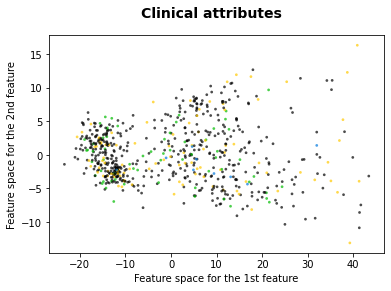

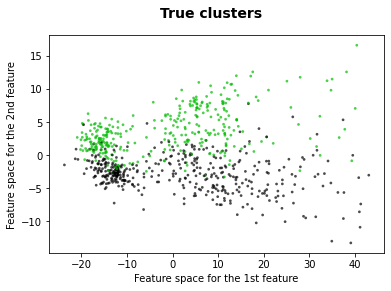

In [ ]:
unique_attributes = merged_clinical_df['demographic.race'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(unique_attributes):
        if x == a: return i

attribute_clusters = merged_clinical_df['demographic.race'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Ethnicity

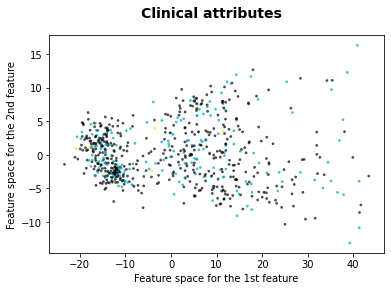

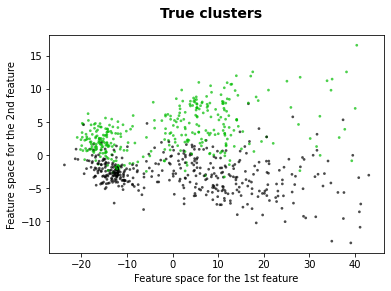

In [ ]:
unique_attributes = merged_clinical_df['demographic.ethnicity'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(unique_attributes):
        if x == a: return i

attribute_clusters = merged_clinical_df['demographic.ethnicity'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Vital status

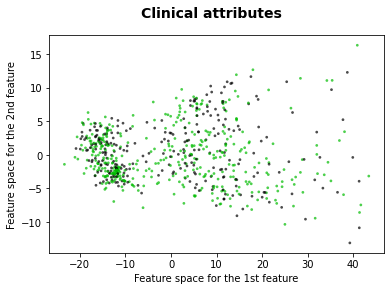

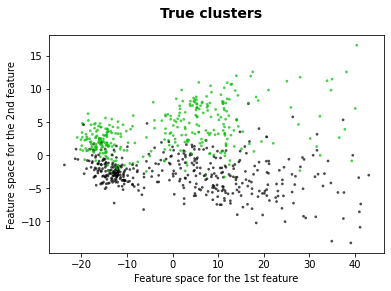

In [ ]:
unique_attributes = merged_clinical_df['demographic.vital_status'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(unique_attributes):
        if x == a: return i

attribute_clusters = merged_clinical_df['demographic.vital_status'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Age

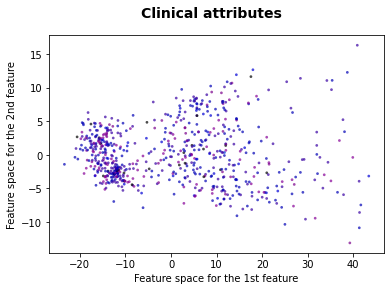

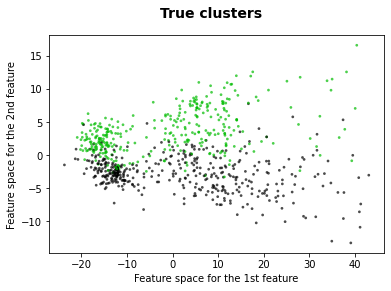

In [ ]:
unique_attributes = merged_clinical_df['demographic.age_at_index'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(range(20,100,10)):
        if x in range(a,a+10): return i

attribute_clusters = merged_clinical_df['demographic.age_at_index'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Gender

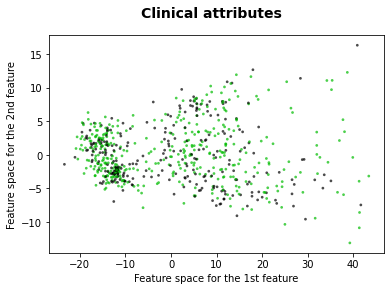

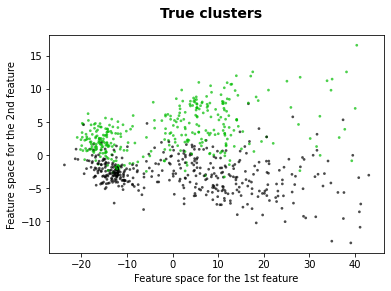

In [ ]:
unique_attributes = merged_clinical_df['demographic.gender'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(unique_attributes):
        if x == a: return i

attribute_clusters = merged_clinical_df['demographic.gender'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Primary diagnosis

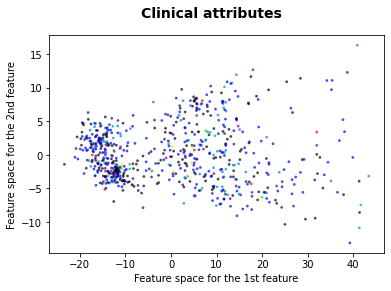

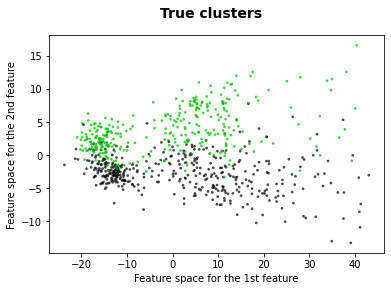

In [ ]:
unique_attributes = merged_clinical_df['primary_diagnosis'].unique()

ds['cnv_normalized_reduced'] = pd.DataFrame(ds['cnv_normalized']).iloc[merged_clinical_df['index']]

def assign_cluster_on_attribute(x):
    for i,a in enumerate(unique_attributes):
        if x == a: return i

attribute_clusters = merged_clinical_df['primary_diagnosis'].map(lambda x: assign_cluster_on_attribute(x)).values

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_normalized_reduced'])
principalComponents2 = pca.fit_transform(ds['cnv_normalized'])

# Plot the clustered dataset
plot_2D_dataset(principalComponents, attribute_clusters, title="Clinical attributes")
plot_2D_dataset(principalComponents2, true_cluster_labels, title="True clusters")

Sadly, none of these clinical variables could explain the batch effect, so we decide to accept its presence, tell the batches apart manually and correct the batch effect with pyComBat (in the next section)

## Correct the batch effect with combat

From cnv visualization, we can notice the likely presence of a batch effect

In particular, it seems that there are two distinguished batches: one very dense on the left and one less dense on the right

We correct the batch effect with combat algorithm

First, let's import combat

In [ ]:
# Import pycombat
!pip install combat
!pip install combat --upgrade
from combat.pycombat import pycombat

Since DBSCAN works badly in high dimensional spaces, we decide to apply it on a PCA-reduced cnv dataset; let's find the principal components to use

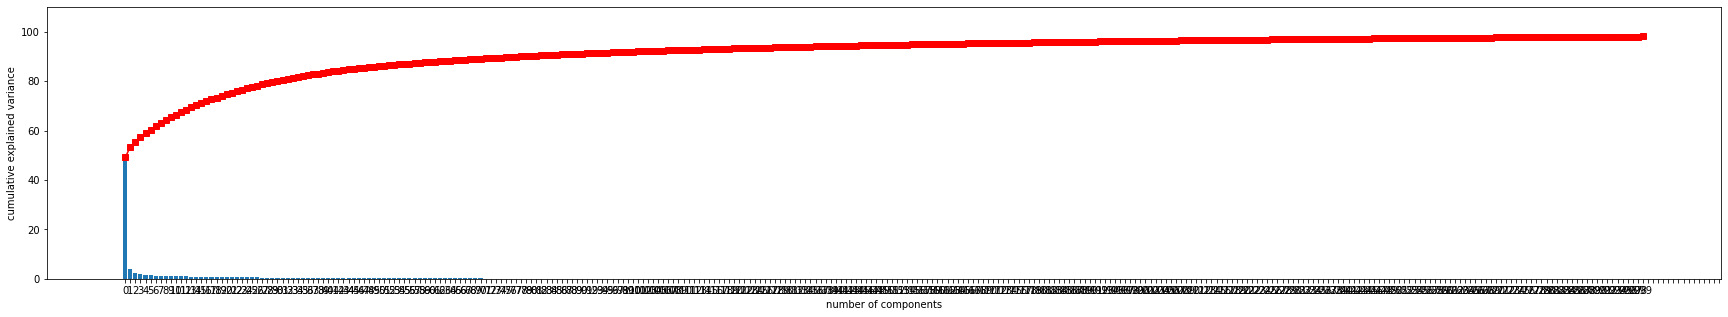

[49.15831541 53.29396826 55.52201895 57.2713148  58.9156556  60.40686542
 61.72995514 63.02498609 64.23924311 65.37308773 66.43793543 67.46446686
 68.42147297 69.34552514 70.2308877  71.0890999  71.86034541 72.61422976
 73.32906048 74.04163546 74.7093696  75.34639274 75.96978821 76.56232492
 77.12895973 77.67698038 78.21198474 78.70402574 79.19176519 79.65778746]


In [ ]:
# Scree plot (principal components explained variance plot)
def elbow(df):
    pca = PCA().fit(df)
    height = pca.explained_variance_ratio_*100
    y_pos = np.arange(df.values.shape[1])
    plt.figure(figsize = (30,5))
    plt.bar(np.arange(300),pca.explained_variance_ratio_[:300]*100)
    plt.xticks(y_pos,np.arange(300)) #df.values.shape[1]
    plt.ylim(0,110)
    plt.plot(np.cumsum(pca.explained_variance_ratio_[:300])*100, 'r-s')
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    print(np.cumsum(pca.explained_variance_ratio_[:30])*100)

elbow(pd.DataFrame(ds['cnv_normalized']))

We can see that the first 30 principal components explain a wide amount of the variance of the dataset (almost 80%)

We can use DBSCAN in the PCA-reduced 30D space to tell the denser batch apart from the less dense one; these two will be the batches which combat algorithm will correct

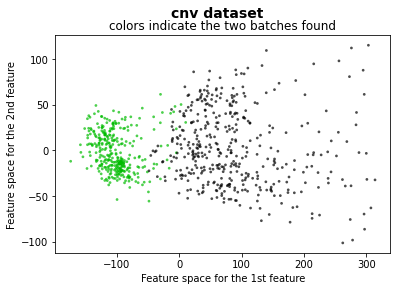

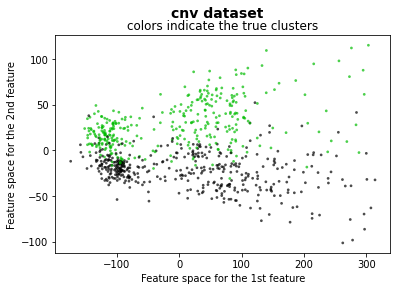

In [ ]:
# Find the denser batch in the PCA(30) space
dbscan = DBSCAN(eps=80, min_samples=10)
pca = PCA(30)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(ds['cnv']))
batch_labels = dbscan.fit_predict(principalComponents)

# Plot the result of the DBSCAN
plot_2D_dataset(principalComponents, batch_labels, title='cnv dataset', caption='colors indicate the two batches found')
# Plot the dataset with its true labels
plot_2D_dataset(principalComponents, true_cluster_labels, title='cnv dataset', caption='colors indicate the true clusters')

Apply combat

In [ ]:
ds['cnv_corrected'] = pycombat(pd.DataFrame(ds['cnv']).T, batch_labels).T
ds['cnv_corrected'].to_csv('cnv_corrected.txt', sep='\t', index_label='case_id')

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


The corrected cnv omic is visualized below: we can see that the two batches are not distinguishable from one another anymore

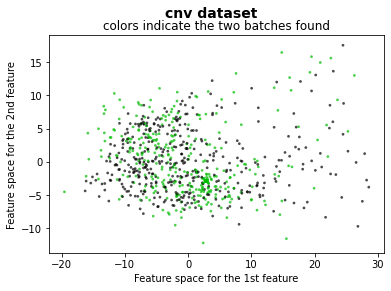

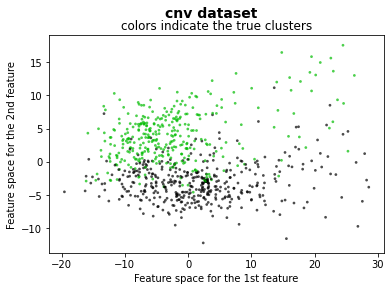

In [ ]:
# Perform a 2D PCA to visualize the dataset
ds['cnv_correct_normalized'] = MinMaxScaler().fit_transform(ds['cnv_corrected'])     # min-max normalize to [0,1] interval
pca = PCA(2)
principalComponents = pca.fit_transform(ds['cnv_correct_normalized'])
plot_2D_dataset(principalComponents, batch_labels, title='cnv dataset', caption='colors indicate the two batches found')
plot_2D_dataset(principalComponents, true_cluster_labels, title='cnv dataset', caption='colors indicate the true clusters')